## Cocktail Recommendation System Evaluation Results

This notebook analyzes the evaluation results from two different approaches:
1. **Full System (Ours)**: Complete graph-based RAG with reflection
2. **LLM + Simple RAG**: LLM with basic embedding-based retrieval

### Evaluation Models:
- **GPT-5**: Evaluation results from v1 files
- **GPT-4o-mini**: Evaluation results from v2 files

### Metrics Analyzed:
- **LLM Judge Scores (1-5 Likert Scale)**:
  - Persuasiveness: "This explanation is convincing to me"
  - Transparency: "I understand why this cocktail is recommended"
  - Accuracy: "Explanation is consistent with query and context"
  - Satisfaction: "I am satisfied with this explanation"
  - Average Score: Mean of the above four metrics

- **System Performance Metrics (0-100)**:
  - Final Overall Score: System's self-evaluation score
  - Task Confidence: Model's confidence in task classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Define file paths for evaluation results
# *_v2.csv가 gpt-5 모델로 평가된 결과
# *_v3.csv가 gpt-4o-mini 모델로 평가된 결과
evaluation_results = {
    'Full System (GPT-5)': 'evaluation/result/gpt-4o-mini_evaluation_v1.csv',
    'Full System (GPT-4o-mini)': 'evaluation/result/gpt-4o-mini_evaluation_v2.csv',
    'w/o graph (GPT-5)': 'evaluation/ablation_llm+rag/result/gpt-4o-mini_ablation_simple_rag_v1.csv',
    'w/o graph (GPT-4o-mini)': 'evaluation/ablation_llm+rag/result/gpt-4o-mini_ablation_simple_rag_v2.csv'
}

# Score columns to analyze
score_columns = [
    'persuasiveness_score',
    'transparency_score',
    'accuracy_score',
    'satisfaction_score',
    'average_score'
]

# Additional columns to analyze
additional_columns = [
    'final_overall_score',
    'task_confidence'
]

# Load all evaluation results
dfs = {}
for model_name, file_path in evaluation_results.items():
    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        # Add model type column
        df['model_type'] = model_name
        
        # Check which columns exist in this dataframe
        available_columns = []
        for col in score_columns + additional_columns:
            if col in df.columns:
                available_columns.append(col)
        
        # Select only available columns and model_type
        dfs[model_name] = df[available_columns + ['model_type']]
        print(f"✅ Loaded {model_name}: {len(df)} samples, columns: {available_columns}")
    except Exception as e:
        print(f"❌ Error loading {model_name}: {e}")

# Combine all dataframes (only with common columns)
common_columns = set(dfs[list(dfs.keys())[0]].columns)
for df in dfs.values():
    common_columns = common_columns.intersection(set(df.columns))

combined_df = pd.concat([df[list(common_columns)] for df in dfs.values()], ignore_index=True)
print(f"\n📊 Total samples loaded: {len(combined_df)}")
print(f"Common columns: {sorted(list(common_columns))}")

✅ Loaded Full System (GPT-5): 200 samples, columns: ['persuasiveness_score', 'transparency_score', 'accuracy_score', 'satisfaction_score', 'average_score', 'final_overall_score', 'task_confidence']
✅ Loaded Full System (GPT-4o-mini): 200 samples, columns: ['persuasiveness_score', 'transparency_score', 'accuracy_score', 'satisfaction_score', 'average_score', 'final_overall_score', 'task_confidence']
✅ Loaded w/o graph (GPT-5): 200 samples, columns: ['persuasiveness_score', 'transparency_score', 'accuracy_score', 'satisfaction_score', 'average_score', 'final_overall_score', 'task_confidence']
✅ Loaded w/o graph (GPT-4o-mini): 200 samples, columns: ['persuasiveness_score', 'transparency_score', 'accuracy_score', 'satisfaction_score', 'average_score', 'final_overall_score', 'task_confidence']

📊 Total samples loaded: 800
Common columns: ['accuracy_score', 'average_score', 'final_overall_score', 'model_type', 'persuasiveness_score', 'satisfaction_score', 'task_confidence', 'transparency_sco

In [3]:
# Calculate statistics for evaluation summary
statistics = []

for model_name in dfs.keys():
    model_df = dfs[model_name]
    
    stats_dict = {'Model': model_name}
    
    # Analyze score columns
    for col in score_columns:
        if col in model_df.columns:
            mean_val = model_df[col].mean()
            std_val = model_df[col].std()
            stats_dict[f'{col}_mean'] = mean_val
            stats_dict[f'{col}_std'] = std_val
            stats_dict[f'{col}_formatted'] = f"{mean_val:.2f} (±{std_val:.2f})"
    
    # Analyze additional columns
    for col in additional_columns:
        if col in model_df.columns:
            mean_val = model_df[col].mean()
            std_val = model_df[col].std()
            stats_dict[f'{col}_mean'] = mean_val
            stats_dict[f'{col}_std'] = std_val
            stats_dict[f'{col}_formatted'] = f"{mean_val:.2f} (±{std_val:.2f})"
    
    statistics.append(stats_dict)

# Create summary dataframe
summary_df = pd.DataFrame(statistics)

# Display formatted summary table
print("📈 Evaluation Summary (Mean ± Std)")
print("="*100)

# Prepare display columns (only those that exist)
display_columns = ['Model']
for col in score_columns + additional_columns:
    if f'{col}_formatted' in summary_df.columns:
        display_columns.append(f'{col}_formatted')

display_df = summary_df[display_columns].copy()

# Rename columns for better display
new_column_names = ['Model']
for col in display_columns[1:]:
    new_name = col.replace('_score_formatted', '').replace('_formatted', '').replace('_', ' ').title()
    new_column_names.append(new_name)

display_df.columns = new_column_names
print(display_df.to_string(index=False))

📈 Evaluation Summary (Mean ± Std)
                    Model Persuasiveness Transparency     Accuracy Satisfaction      Average  Final Overall Task Confidence
      Full System (GPT-5)   2.00 (±1.15) 2.61 (±1.33) 2.15 (±1.43) 1.94 (±1.16) 2.17 (±1.18) 69.53 (±20.11)   89.85 (±1.22)
Full System (GPT-4o-mini)   2.98 (±1.00) 3.82 (±1.20) 3.24 (±1.13) 3.00 (±1.00) 3.26 (±1.05) 69.53 (±20.11)   89.85 (±1.22)
        w/o graph (GPT-5)   1.92 (±1.13) 2.60 (±1.28) 2.06 (±1.32) 1.87 (±1.08) 2.11 (±1.13) 70.17 (±10.68)   89.75 (±1.57)
  w/o graph (GPT-4o-mini)   2.83 (±1.00) 3.65 (±1.21) 3.12 (±1.15) 2.83 (±1.00) 3.11 (±1.06) 70.17 (±10.68)   89.75 (±1.57)


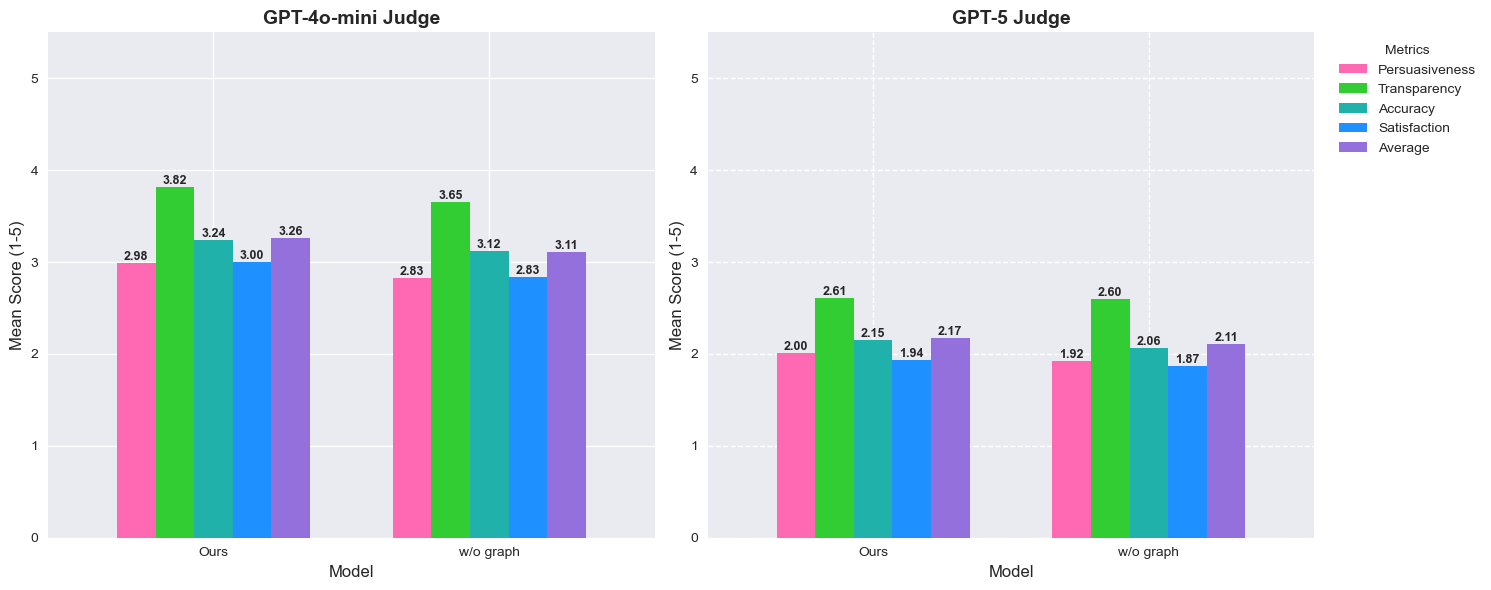

In [4]:
# Create comprehensive comparison charts
# Color scheme matching the reference image
colors = ['#ff69b4', '#32cd32', '#20b2aa', '#1e90ff', '#9370db']  # Pink, Green, Teal, Blue, Purple

# Prepare data for visualization
available_mean_cols = []
for col in score_columns:  # Only LLM judge scores
    if f'{col}_mean' in summary_df.columns:
        available_mean_cols.append(col)

mean_scores = summary_df[['Model'] + [f'{col}_mean' for col in available_mean_cols]].copy()

# Rename columns for better display
new_names = ['Model']
for col in available_mean_cols:
    new_name = col.replace('_score', '').replace('_', ' ').title()
    new_names.append(new_name)
mean_scores.columns = new_names

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Filter data for each evaluation model
gpt4o_data = mean_scores[mean_scores['Model'].str.contains('GPT-4o-mini')].copy()
gpt5_data = mean_scores[mean_scores['Model'].str.contains('GPT-5')].copy()

# Simplify model names
gpt4o_data['Model'] = gpt4o_data['Model'].str.replace('Full System (GPT-4o-mini)', 'Ours')
gpt4o_data['Model'] = gpt4o_data['Model'].str.replace('w/o graph (GPT-4o-mini)', 'w/o graph')
gpt5_data['Model'] = gpt5_data['Model'].str.replace('Full System (GPT-5)', 'Ours')
gpt5_data['Model'] = gpt5_data['Model'].str.replace('w/o graph (GPT-5)', 'w/o graph')

# Set Model as index for plotting
gpt4o_data.set_index('Model', inplace=True)
gpt5_data.set_index('Model', inplace=True)

# Select only LLM judge metrics
score_metrics = [col for col in gpt4o_data.columns
                 if any(s in col.lower() for s in
                        ['persuasiveness', 'transparency', 'accuracy', 'satisfaction', 'average'])]

# Plot GPT-4o-mini comparison
if len(gpt4o_data) > 0:
    gpt4o_data[score_metrics].plot(kind='bar', ax=ax1, width=0.7, color=colors)
    ax1.set_title('GPT-4o-mini Judge', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Mean Score (1-5)', fontsize=12)
    ax1.set_xlabel('Model', fontsize=12)
    ax1.set_ylim(0, 5.5)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')
    ax2.grid(True, alpha=1, linestyle='--', axis='y')
    ax2.grid(True, alpha=1, linestyle='--', axis='x')
    ax1.get_legend().remove()  # Remove legend from left subplot
    
    # Add value labels
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.2f', fontsize=9, fontweight='bold')

# Plot GPT-5 comparison
if len(gpt5_data) > 0:
    gpt5_data[score_metrics].plot(kind='bar', ax=ax2, width=0.7, color=colors)
    ax2.set_title('GPT-5 Judge', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Mean Score (1-5)', fontsize=12)
    ax2.set_xlabel('Model', fontsize=12)
    ax2.set_ylim(0, 5.5)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='center')
    ax2.grid(True, alpha=1, linestyle='--', axis='y')
    ax2.grid(True, alpha=1, linestyle='--', axis='x')
    ax2.legend(title='Metrics', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
    
    # Add value labels
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.2f', fontsize=9, fontweight='bold')

# Add subtle background color
ax1.set_facecolor('#EAEAF1')
ax2.set_facecolor('#EAEAF1')

plt.tight_layout()
plt.show()

In [ ]:
# 퍼센트 계산식: ((Ours - w/o graph) / w/o graph) * 100 → w/o graph 대비 증감률
# w/o graph 대비 Ours가 (%)만큼 향상
print(f"\n🔍 Key Findings:")

def r2(x):  # chart와 동일한 소수 2자리 반올림
    return round(float(x), 2)

def fmt_pct_from_chart(ours, rag):
    o, r = r2(ours), r2(rag)
    if abs(r) < 1e-9:  # Avoid division by zero
        return "(N/A)"
    pct = ((o - r) / r) * 100.0
    sign = "+" if pct >= 0 else ""
    return f"({sign}{pct:.2f}%)"

# Debug
print(f"\n🔧 Debug - GPT-4o-mini models: {list(gpt4o_data.index) if len(gpt4o_data) > 0 else 'None'}")
print(f"🔧 Debug - GPT-5 models: {list(gpt5_data.index) if len(gpt5_data) > 0 else 'None'}")

# Compare performance within each evaluation model
if len(gpt4o_data) > 0:
    print("\n📊 GPT-4o-mini Evaluation:")
    for metric in score_metrics:
        if len(gpt4o_data) == 2:  # Both models present
            ours_score = gpt4o_data.loc['Ours', metric] if 'Ours' in gpt4o_data.index else None
            rag_score  = gpt4o_data.loc['w/o graph', metric] if 'w/o graph' in gpt4o_data.index else None

            if ours_score is not None and rag_score is not None:
                # 차트와 동일한 반올림값으로 diff, % 모두 계산
                diff_points = r2(ours_score) - r2(rag_score)
                pct_str = fmt_pct_from_chart(ours_score, rag_score)
                if diff_points > 0:
                    print(f"  • {metric}: Ours outperforms w/o graph by {diff_points:.2f} points {pct_str}")
                elif diff_points < 0:
                    print(f"  • {metric}: w/o graph outperforms Ours by {abs(diff_points):.2f} points {pct_str}")
                else:
                    print(f"  • {metric}: Ours and w/o graph perform equally (0.00 points difference)")

if len(gpt5_data) > 0:
    print("\n📊 GPT-5 Evaluation:")
    for metric in score_metrics:
        if len(gpt5_data) == 2:  # Both models present
            ours_score = gpt5_data.loc['Ours', metric] if 'Ours' in gpt5_data.index else None
            rag_score  = gpt5_data.loc['w/o graph', metric] if 'w/o graph' in gpt5_data.index else None

            if ours_score is not None and rag_score is not None:
                diff_points = r2(ours_score) - r2(rag_score)
                pct_str = fmt_pct_from_chart(ours_score, rag_score)
                if diff_points > 0:
                    print(f"  • {metric}: Ours outperforms w/o graph by {diff_points:.2f} points {pct_str}")
                elif diff_points < 0:
                    print(f"  • {metric}: w/o graph outperforms Ours by {abs(diff_points):.2f} points {pct_str}")
                else:
                    print(f"  • {metric}: Ours and w/o graph perform equally (0.00 points difference)")

            


🔍 Key Findings:

🔧 Debug - GPT-4o-mini models: ['Ours', 'w/o graph']
🔧 Debug - GPT-5 models: ['Ours', 'w/o graph']

📊 GPT-4o-mini Evaluation:
  • Persuasiveness: Ours outperforms w/o graph by 0.15 points (+5.30%)
  • Transparency: Ours outperforms w/o graph by 0.17 points (+4.66%)
  • Accuracy: Ours outperforms w/o graph by 0.12 points (+3.85%)
  • Satisfaction: Ours outperforms w/o graph by 0.17 points (+6.01%)
  • Average: Ours outperforms w/o graph by 0.15 points (+4.82%)

📊 GPT-5 Evaluation:
  • Persuasiveness: Ours outperforms w/o graph by 0.08 points (+4.17%)
  • Transparency: Ours outperforms w/o graph by 0.01 points (+0.38%)
  • Accuracy: Ours outperforms w/o graph by 0.09 points (+4.37%)
  • Satisfaction: Ours outperforms w/o graph by 0.07 points (+3.74%)
  • Average: Ours outperforms w/o graph by 0.06 points (+2.84%)
